In [36]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets

### Create data loaders for training, validation, and test sets
def get_loaders():
    train_dir = 'data/train'
    valid_dir = 'data/valid'
    test_dir =  'data/test'

    train_transform = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    valid_transform = transforms.Compose([transforms.Resize(240, interpolation=2),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    test_transform = transforms.Compose([transforms.Resize(240, interpolation=2),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)
    test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
    testloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=64)

    loaders = {}
    loaders['train'] = trainloader
    loaders['valid'] = validloader
    loaders['test']  = testloader
    
    label_mapping = ['melanoma', 'nevus', 'seborrheic_keratosis']
    loaders['label_mapping'] = label_mapping
    
    return loaders

# loaders = get_loaders()
# print(loaders['label_mapping'])

# for data, target in loaders['valid']:
#     for i in range(len(target)):
#         print("{}: {}".format(target[i], loaders['label_mapping'][target[i]]))
#         break

def preprocess_image(img_path):
    '''
    Given a path to an image files, returns a tensor that can be used in one of the 
    Pytorch torchvision models
    
    Args:
        img_path: path to an image
        
    Returns:
        A tensor that can be used in one of the Pytorch torchvision models
    '''
    img = Image.open(img_path)

    transform = transforms.Compose([
        transforms.Resize(224, interpolation=2),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(img)
    img_tensor = img_tensor.view(1, 3, 224, 224) #add in a dimension for batch size.
    return img_tensor

In [13]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

def get_model(fully_trainable=False):
    ## Specify model architecture.  Use a pretrained vgg16 model and replace the classifier.
    model = models.vgg16(pretrained=True)

    # Freeze parameters so we don't backprop through them
    if not fully_trainable:
        for name, param in model.named_parameters():
            param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('fc1',    nn.Linear(25088, 512)),
                              ('relu1',   nn.ReLU()),
                              ('drop1',  nn.Dropout(0.25)),
                              ('fc2',    nn.Linear(512, 512)),
                              ('relu2',   nn.ReLU()),
                              ('drop2',  nn.Dropout(0.25)),
                              ('fc3',    nn.Linear(512, 3)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model
    
#print(model_transfer)

In [10]:
import numpy as np

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    valid_loss_min = np.Inf # initialize tracker for minimum validation loss
    
    if use_cuda:
        print("using GPU for training.")
        model = model.cuda()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:  # move to GPU
                data, target = data.cuda(), target.cuda()
            
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            #print("data.shape: {}, output.shape: {}, target.shape: {}".format(data.shape, output.shape, target.shape))
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('    Validation loss decreased ({:.6f} --> {:.6f}).  Saving model.'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model

In [11]:
#######################
### Train the model ###
#######################
import os

model      = get_model()
model_name = 'skin_tumors_model.pt'
n_epochs   = 10
loaders    = get_loaders()
criterion  = nn.NLLLoss()
optimizer  = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
    
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if os.path.exists(model_name):
    #load the saved model from disk
    print("loading saved model: {}".format(model_name))
    model.load_state_dict(torch.load(model_name))

model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, model_name)



using GPU for training.
Epoch: 1 	Training Loss: 0.875150 	Validation Loss: 0.813297
    Validation loss decreased (inf --> 0.813297).  Saving model.
Epoch: 2 	Training Loss: 0.716616 	Validation Loss: 0.706682
    Validation loss decreased (0.813297 --> 0.706682).  Saving model.
Epoch: 3 	Training Loss: 0.705620 	Validation Loss: 0.791089
Epoch: 4 	Training Loss: 0.669240 	Validation Loss: 0.729379
Epoch: 5 	Training Loss: 0.646608 	Validation Loss: 0.641725
    Validation loss decreased (0.706682 --> 0.641725).  Saving model.
Epoch: 6 	Training Loss: 0.649031 	Validation Loss: 0.877196
Epoch: 7 	Training Loss: 0.633435 	Validation Loss: 0.754701
Epoch: 8 	Training Loss: 0.634179 	Validation Loss: 0.638562
    Validation loss decreased (0.641725 --> 0.638562).  Saving model.
Epoch: 9 	Training Loss: 0.616414 	Validation Loss: 0.822625
Epoch: 10 	Training Loss: 0.625163 	Validation Loss: 0.705805


In [16]:
#################################
### Test the model's accuracy ###
#################################
model_name = 'skin_tumors_model.pt'
loaders    = get_loaders()
use_cuda   = torch.cuda.is_available()
criterion  = nn.NLLLoss()
model      = get_model()

if use_cuda:
    model = model.cuda()
model.load_state_dict(torch.load(model_name))
model.eval()

#set in itial values
test_loss = 0.
correct = 0.
total = 0.

for batch_idx, (data, target) in enumerate(loaders['test']):
    # move to GPU
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

print('Test Loss: {:.6f}'.format(test_loss))
print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))


Test Loss: 0.790399


Test Accuracy: 68% (408/600)


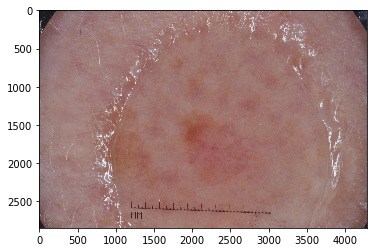

data/test/melanoma/ISIC_0014434.jpg
	melanoma:		8.24%
	nevus:			26.40%
	seborrheic_keratosis:	65.36%


In [89]:
#################################
### Test the model's accuracy ###
#################################
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random, os
%matplotlib inline

def random_file(dir):
    file = os.path.join(dir, random.choice(os.listdir(dir)));
    if os.path.isdir(file):
        return random_file(file)
    else:
        return file
    
test_images_path = 'data/test'
random_file = random_file(test_images_path)

#load the file
img = cv2.imread(random_file)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#convert the image into a tensor that the model can process
img_tensor = preprocess_image(random_file)
if next(model.parameters()).is_cuda:
    img_tensor = img_tensor.cuda()

#get the model's predictions
output = model(img_tensor)
output = output.cpu().detach()

#print the results
label_mapping = ['melanoma', 'nevus', 'seborrheic_keratosis']
print(random_file)
print("\t{}:\t\t{:.2f}%".format(label_mapping[0],   100.*np.exp(output[0][0])))
print("\t{}:\t\t\t{:.2f}%".format(label_mapping[1], 100.*np.exp(output[0][1])))
print("\t{}:\t{:.2f}%".format(label_mapping[2],     100.*np.exp(output[0][2])))
#print( np.exp(output[0][0])+np.exp(output[0][1])+np.exp(output[0][2]) ) #output shoud add up to 1